# Testes de modelo de elementos finitos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd

In [2]:
#Define os parâmetros da grade
n_viga = 6
n_col = n_viga + 1
n_linhas = 6
n_div = 5

#Inicia a matriz com zeros para preencher
aux_lines = n_linhas + (n_div - 1)*(n_linhas - 1)
aux_col = n_div*n_viga + 1
Mat = np.zeros((aux_lines, aux_col))

#Itera preenchendo a grade
for i in range(Mat.shape[0]):
    if i%n_div == 0:
        #Elementos na borda da viga
        j = int(i/n_div)
        stepH = n_viga*n_div + 1
        stepV = n_col*(n_div - 1) + stepH
        start = j*stepV
        stop = j*stepV + stepH

        Mat[i,:] = np.arange(start, stop, 1)
    else:
        #Elementos dentro da viga
        Mat[i, ::n_div] = np.arange(stop, stop + n_col, 1)
        stop += n_col
print(Mat)

def conH(matrix):
    #Retorna as conexões horizontais da matriz
    conH = []
    for i in range(n_linhas):
        seq1 = matrix[i*n_div,:-1]
        seq2 = matrix[i*n_div, 1:]
        conH.append(list(zip(seq1,seq2)))
    return conH

def conV(matrix):
    #Retorna as conexões verticais da matriz
    conV = []
    for i in range(n_col):
        seq1 = matrix[:-1, i*n_div]
        seq2 = matrix[1:, i*n_div]
        conV.append(list(zip(seq1,seq2)))
    return conV

conexH = conH(Mat)
conexV = conV(Mat)
conex = [x for xs in conexH+conexV for x in xs]
# print(conex)
print('Número de elementos:', max(Mat[-1,:])+1)
print('Número de conexões:', len(conex))

[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
   28.  29.  30.]
 [ 31.   0.   0.   0.   0.  32.   0.   0.   0.   0.  33.   0.   0.   0.
    0.  34.   0.   0.   0.   0.  35.   0.   0.   0.   0.  36.   0.   0.
    0.   0.  37.]
 [ 38.   0.   0.   0.   0.  39.   0.   0.   0.   0.  40.   0.   0.   0.
    0.  41.   0.   0.   0.   0.  42.   0.   0.   0.   0.  43.   0.   0.
    0.   0.  44.]
 [ 45.   0.   0.   0.   0.  46.   0.   0.   0.   0.  47.   0.   0.   0.
    0.  48.   0.   0.   0.   0.  49.   0.   0.   0.   0.  50.   0.   0.
    0.   0.  51.]
 [ 52.   0.   0.   0.   0.  53.   0.   0.   0.   0.  54.   0.   0.   0.
    0.  55.   0.   0.   0.   0.  56.   0.   0.   0.   0.  57.   0.   0.
    0.   0.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
   73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
   87.  88.  89.]
 [ 90.   0.   0.   0.   0.  

In [3]:
#Preencher matriz de rigidez
n_el = max(Mat[-1, :]) + 1 #Conta o número de elementos
gdl = 2 #Graus de liberdade no modelo considerado

K = sparse.lil_array((int(n_el)*gdl,int(n_el)*gdl))
M = sparse.lil_array((int(n_el)*gdl,int(n_el)*gdl))

#Propriedades de seção e material da viga aço perfil IPE 120
A = 13.2/(100**2) #m²
rho = 7850 #kg/m³
E = 200*10**9 #Pa
I = 318/(10**8)  #m^4
L = 4.6 #m

lx = L/(n_viga*n_div)
ly = L/((n_linhas-1)*n_div)

def rigidez(E,I,l):
    #Modelo de viga com 2 GdL
    return (E*I/l**3) * np.array([[12, 6*l, -12, 6*l], 
                                  [6*l, 4*l**2, -6*l, 2*l**2], 
                                  [-12, -6*l, 12, -6*l], 
                                  [6*l, 2*l**2, -6*l, 4*l**2]])

def inercia(rho,A,l):
    #Modelo de viga com 2 GdL
    return (rho*A*l/420) * np.array([[156, 22*l, 54, -13*l], 
                                     [22*l, 4*l**2, 13*l, -3*l**2], 
                                     [54, 13*l, 156, -22*l], 
                                     [-13*l, -3*l**2, -22*l, 4*l**2]])

kex = rigidez(E,I,lx)
mex = inercia(rho,A,lx)
key = rigidez(E,I,ly)
mey = inercia(rho,A,ly)

for i in range(len(conex)):
    #Preenche a matriz de rigidez com base no vetor de conexões
    a = int(conex[i][0])
    b = int(conex[i][1])
    
    if b == a + 1: #Conexão horizontal
        ke = kex
        me = mex
    else: #Conexão vertical
        ke = key
        me = mey
    auxa_i = a*gdl
    auxa_o = a*gdl+gdl
    auxb_i = b*gdl
    auxb_o = b*gdl+gdl

    K[auxa_i:auxa_o, auxa_i:auxa_o] += ke[0:2,0:2]
    K[auxb_i:auxb_o, auxb_i:auxb_o] += ke[2:,2:]
    K[auxa_i:auxa_o, auxb_i:auxb_o] += ke[0:2,2:]
    K[auxb_i:auxb_o, auxa_i:auxa_o] += ke[2:,0:2]

    M[auxa_i:auxa_o, auxa_i:auxa_o] += me[0:2,0:2]
    M[auxb_i:auxb_o, auxb_i:auxb_o] += me[2:,2:]
    M[auxa_i:auxa_o, auxb_i:auxb_o] += me[0:2,2:]
    M[auxb_i:auxb_o, auxa_i:auxa_o] += me[2:,0:2]

print(M.shape)

(652, 652)


In [4]:
from scipy.sparse import csr_matrix

def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

In [5]:
print(-2, gdl*(-1-n_div*n_col), gdl*stepV, (stepV + stepH - 1)*gdl)

-2 -72 118 178


In [6]:
#Condições de contorno
#Pinado nas extremidades da segunda e última linha
K = delete_from_csr(K.tocsr(), [-2, gdl*(-1-n_div*n_col), gdl*stepV, (stepV + stepH - 1)*gdl], 
                    [-2, gdl*(-1-n_div*n_viga), gdl*stepV, (stepV + stepH - 1)*gdl])

M = delete_from_csr(M.tocsr(), [-2, gdl*(-1-n_div*n_col), gdl*stepV, (stepV + stepH - 1)*gdl], 
                    [-2, gdl*(-1-n_div*n_viga), gdl*stepV, (stepV + stepH - 1)*gdl])

In [7]:
#Amortecimento proporcional
alpha = 0.0001 # amortecimento proporcional
beta1 = 0.0000005 # amortecimento proporcional
C = alpha*M + beta1*K # amortecimento proporcional

In [8]:
#Definimos os parâmetros amostrais
fs = 1024/5 # taxa de amostragem
tf = 256/50 # tempo total 
Np = int(tf*fs) # número de pontos
t = np.linspace(0,tf,Np,endpoint=False)

w = np.linspace(0,fs/2,int(Np/2),endpoint=False) # vetor freqência em Hz
H = np.zeros((M.shape[0], M.shape[0], w.shape[0]),dtype = 'complex_')

for n in range(0,len(w)):
    H[:,:,n] = np.linalg.inv(K.toarray() - M.toarray()*((2*np.pi*w[n])**2) + complex(0,1)*C.toarray()*2*np.pi*w[n]) # Calcula as 4 componentes de H analiticamente

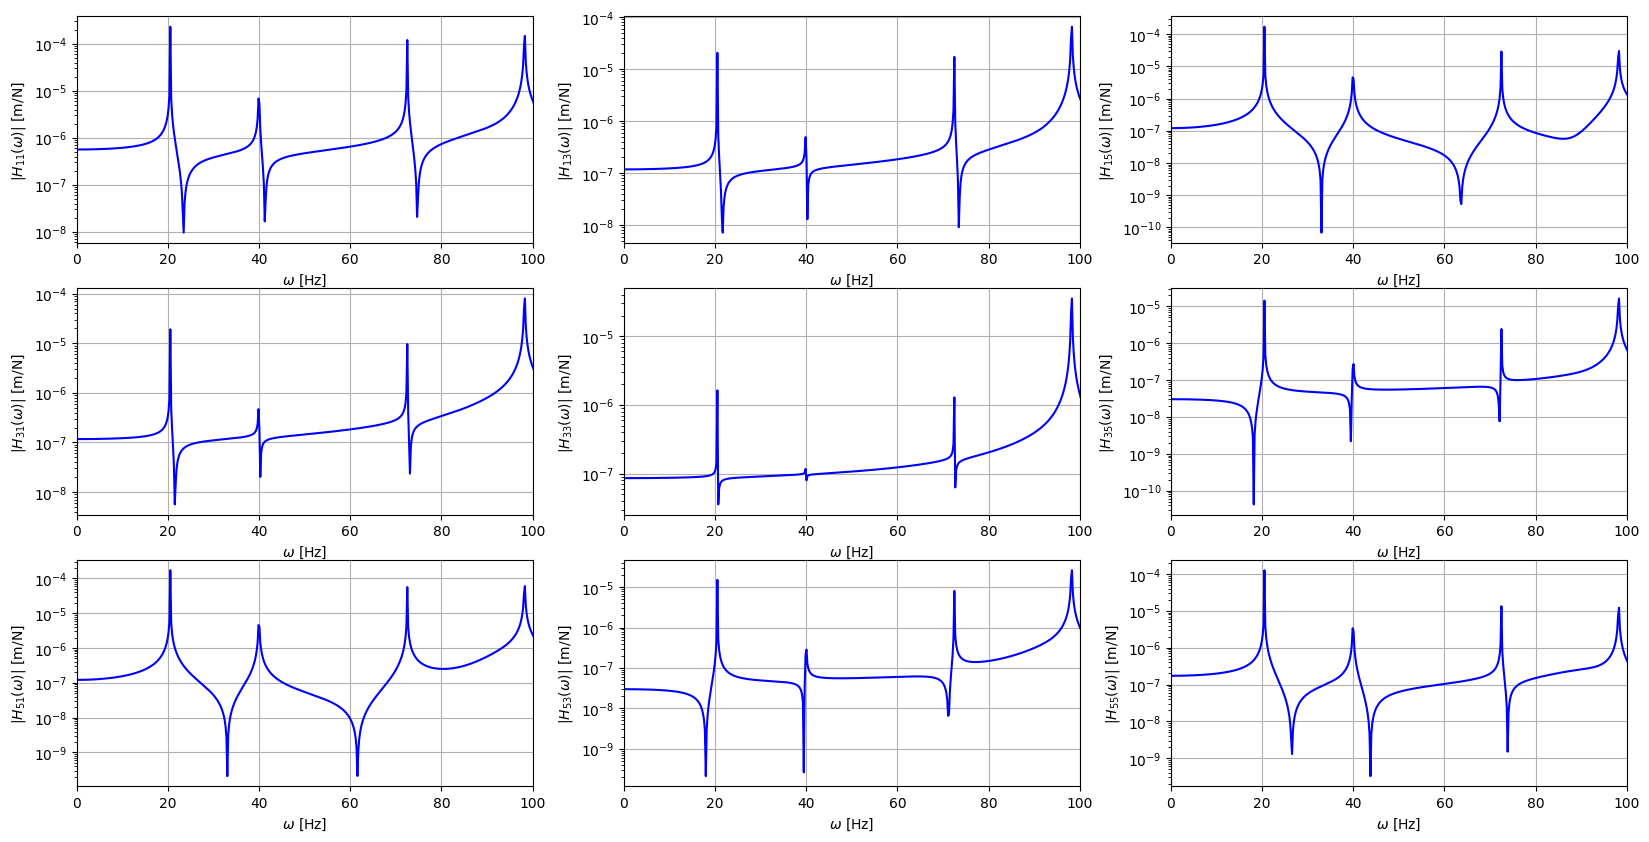

In [9]:
# Vamos analisar apenas a translação dos 3 primeiros modos
fig, ax = plt.subplots(3, 3, figsize=(20,10))
ax[0,0].grid(visible=True, which='major', axis='both')
ax[0,0].semilogy(w, abs(H[0,0,:]), 'b') #Elemento 0
ax[0,0].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{11} (\omega)|$ [m/N] ')
ax[0,0].set_xlim([0,100])
ax[0,1].grid(visible=True, which='major', axis='both')
ax[0,1].semilogy(w, abs(H[0,2*n_div,:]), 'b') #Elemento 1
ax[0,1].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{13} (\omega)|$ [m/N] ')
ax[0,1].set_xlim([0,100])
ax[0,2].grid(visible=True, which='major', axis='both')
ax[0,2].semilogy(w, abs(H[0,4*n_div,:]), 'b') #Elemento 2
ax[0,2].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{15} (\omega)|$ [m/N] ')
ax[0,2].set_xlim([0,100])


ax[1,0].grid(visible=True, which='major', axis='both')
ax[1,0].semilogy(w, abs(H[2*n_div,0,:]), 'b')
ax[1,0].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{31} (\omega)|$ [m/N] ')
ax[1,0].set_xlim([0,100])
ax[1,1].grid(visible=True, which='major', axis='both')
ax[1,1].semilogy(w, abs(H[2*n_div,2*n_div,:]), 'b')
ax[1,1].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{33} (\omega)|$ [m/N] ')
ax[1,1].set_xlim([0,100])
ax[1,2].grid(visible=True, which='major', axis='both')
ax[1,2].semilogy(w, abs(H[2*n_div,4*n_div,:]), 'b')
ax[1,2].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{35} (\omega)|$ [m/N] ')
ax[1,2].set_xlim([0,100])

ax[2,0].grid(visible=True, which='major', axis='both')
ax[2,0].semilogy(w, abs(H[4*n_div,0*n_div,:]), 'b')
ax[2,0].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{51} (\omega)|$ [m/N] ')
ax[2,0].set_xlim([0,100])
ax[2,1].grid(visible=True, which='major', axis='both')
ax[2,1].semilogy(w, abs(H[4*n_div,2*n_div,:]), 'b')
ax[2,1].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{53} (\omega)|$ [m/N] ')
ax[2,1].set_xlim([0,100])
ax[2,2].grid(visible=True, which='major', axis='both')
ax[2,2].semilogy(w, abs(H[4*n_div,4*n_div,:]), 'b')
ax[2,2].set(xlabel='$\omega$ [Hz]', ylabel='$|H_{55} (\omega)|$ [m/N] ')
ax[2,2].set_xlim([0,100])

plt.show()

In [10]:
df = np.transpose(
      np.asarray(
            pd.read_table('..\..\Dataset\Treino dataset\zzzAA0.TXT', sep='\t', skiprows=10)))

t = df[0, :]
df = df[1:, :]

c:\Users\Guilherme Zerwes\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


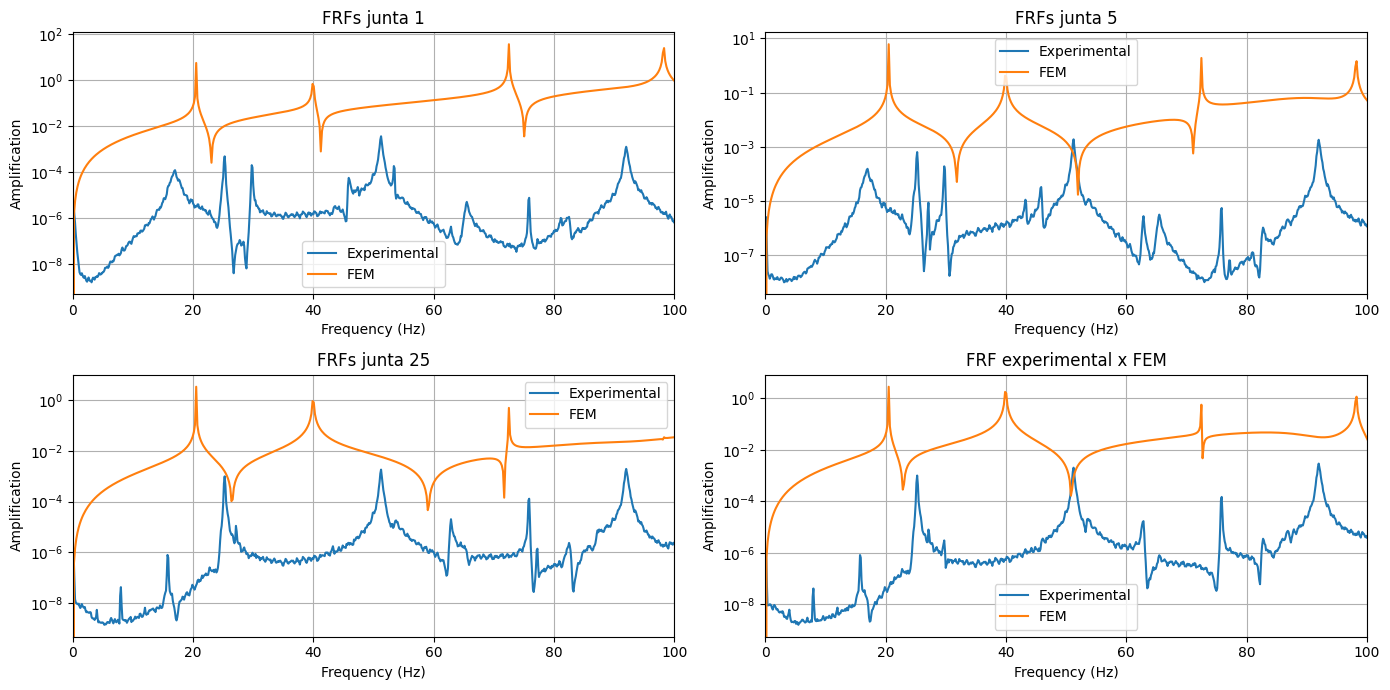

In [11]:
from scipy.signal import csd

f, amp = csd(df[0,:], df[0,:], fs=1024.0, window='hann', nperseg=int(df.shape[1]/32), 
                nfft=int(df.shape[1]/32), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].semilogy(f,amp, label='Experimental')
ax[0,0].semilogy(w, abs(H[n_div,n_div,:]*((2*np.pi*w)**2)), label='FEM')
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('Amplification')
ax[0,0].set_title(f'FRFs junta 1')
ax[0,0].grid()
ax[0,0].set_xlim([0,100])
ax[0,0].legend()


f, amp = csd(df[4,:], df[4,:], fs=1024.0, window='hann', nperseg=int(df.shape[1]/32), 
                nfft=int(df.shape[1]/32), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')

ax[0,1].semilogy(f,amp, label='Experimental')
ax[0,1].semilogy(w, abs(H[(n_col-1)*n_div,(n_col-1)*n_div,:]*((2*np.pi*w)**2)), label='FEM')
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('Amplification')
ax[0,1].set_title(f'FRFs junta 5')
ax[0,1].grid()
ax[0,1].set_xlim([0,100])
ax[0,1].legend()


f, amp = csd(df[25,:], df[25,:], fs=1024.0, window='hann', nperseg=int(df.shape[1]/32), 
                nfft=int(df.shape[1]/32), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')

ax[1,0].semilogy(f,amp, label='Experimental')
ax[1,0].semilogy(w, abs(H[(-1-n_div*n_viga),(-1-n_div*n_viga),:]*((2*np.pi*w)**2)), label='FEM')
ax[1,0].set_xlabel('Frequency (Hz)')
ax[1,0].set_ylabel('Amplification')
ax[1,0].set_title(f'FRFs junta 25')
ax[1,0].grid()
ax[1,0].set_xlim([0,100])
ax[1,0].legend()


f, amp = csd(df[-1,:], df[-1,:], fs=1024.0, window='hann', nperseg=int(df.shape[1]/32), 
                nfft=int(df.shape[1]/32), detrend='constant', return_onesided=True, scaling='density', 
                axis=-1, average='mean')

ax[1,1].semilogy(f,amp, label='Experimental')
ax[1,1].semilogy(w, abs(H[-1-n_div,-1-n_div,:]*((2*np.pi*w)**2)), label='FEM')
ax[1,1].set_xlabel('Frequency (Hz)')
ax[1,1].set_ylabel('Amplification')
ax[1,1].set_title(f'FRFs junta 30')
ax[1,1].grid()
ax[1,1].set_xlim([0,100])
ax[1,1].legend()

plt.tight_layout()
plt.show()